In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import json
from math import isnan
import seaborn as sb
from scipy import stats
import scipy.stats as sts
import datetime
from datetime import datetime
%matplotlib inline

In [20]:
def magic(date):
    date = date[:4]+' '+date[5:7]+' '+date[8:]       
    return date[:18]
def prepare_dataframe(folder,course_id,subject=None):
    
    """
    возвращает таблицу с колонками: element_progress_id, hours_diff, user_id, module_is_achieved, 
                                    size_of_answer, size_of_review, rewiew_time, course_element_id
                                    id from solution_log
    """
    if subject is None:
        path = f'{folder}/{course_id}/'
    else:
        path = f'{folder}/{subject}/{course_id}/'
    try:
        solution_log = pd.read_csv(path+'solution_log.csv')
    except:
        raise Exception(f'No such file or directory',path,'solution_log.csv')
    
    
    solution_log['size_of_answer'] = solution_log['users_answer'].apply(lambda x: len(str(x)))
    solution_log['size_of_review'] = solution_log['review'].apply(lambda x: len(str(x)))

    solution_log = solution_log.dropna(subset=['review_time'])
    solution_log = solution_log.reset_index(drop=True)
    
    ###
    difference = []
    for i in range(len(solution_log['review_time'])):
        a = datetime.strptime(magic(solution_log['submission_time'][i]), '%Y %m %d %H:%M:%S')
        b = datetime.strptime(magic(solution_log['review_time'][i]), '%Y %m %d %H:%M:%S')
        difference.append(b - a)
    solution_log['time_of_expectation'] = difference
    solution_log = solution_log.drop(columns=['submission_time'])
    ###
    
    solution_log['hours_diff']=solution_log['time_of_expectation'].apply(lambda x: x.days*24+x.seconds//3600)
    pre_df = solution_log[['element_progress_id','hours_diff', 'size_of_answer', 'size_of_review', 'tries_count', 'review_time']]
    pre_df['id_from_sl'] = solution_log['id']
    pre_df['id']=pre_df['element_progress_id'].astype(int)
    ##pre_df = pre_df.drop(columns=['element_progress_id'])
    try:
        user_element_progress = pd.read_csv(path+'user_element_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_element_progress.csv')
    user_element_progress['id'] = user_element_progress['id'].astype(int)
    user_element_progress.reset_index(drop=True)
    user_element_progress = user_element_progress[['id','user_id', 'course_element_id', 'course_id']]
    
    try:
        user_module_progress = pd.read_csv(path+'user_module_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_module_progress.csv')
    user_module_progress['is_achieved'] = user_module_progress['is_achieved'].fillna(False).astype(int)
    user_module_progress = user_module_progress[['user_id','is_achieved']]
    
    
    df = pre_df.merge(user_element_progress).merge(user_module_progress, on='user_id').drop(columns='id')
    return df

In [21]:
subjects = ['math','physics','linguo']
coursers = [['293','294','295'], ['345','346'],['267','268']]
df_start = pd.DataFrame()
df_new = pd.DataFrame()
df_old = pd.DataFrame()
for s in enumerate(subjects):
        for c in coursers[s[0]]:
            tmp_df = prepare_dataframe(folder='courses_with_manual_check',subject = s[1],course_id = c)
            for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
            df_start=df_start.append(tmp_df, ignore_index=True)
new_coursers_id = [370,67,71,76,84,226,231,233,251,252,259,307,318]
old_coursers_id = [6,7,23,24,25,26,27,28,29,30,31,32,33,36,40,41,42,45,48,49,50,52,53,54,60]
for ID in new_coursers_id:
    tmp_df = prepare_dataframe(folder='new_courses',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df_new=df_new.append(tmp_df, ignore_index=True)
df_new = df_new.sort_values(by = ['user_id', 'review_time'])
for ID in old_coursers_id:
    tmp_df = prepare_dataframe(folder='old_courses',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df_old=df_old.append(tmp_df, ignore_index=True)
df_start = df_start.sort_values(by = ['user_id', 'course_id'])
df_new = df_new.sort_values(by = ['user_id', 'course_id'])
df_old = df_old.sort_values(by = ['user_id', 'course_id'])

<ipython-input-20-0d80b7228016>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_df['id_from_sl'] = solution_log['id']
<ipython-input-20-0d80b7228016>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_df['id']=pre_df['element_progress_id'].astype(int)


In [22]:
def q_9(x):
    return np.quantile(x, 0.9) 
q_9.__name__ = '0.9 quantile'
df_start = df_start.groupby(['user_id', 'course_id']).agg({'hours_diff':['mean',q_9,'median','max','std','min'], 
                         'size_of_answer':['mean','std'], 
                         'size_of_review':['mean','std'],
                         'is_achieved':'max'})
df_start.columns = ['_'.join(col) for col in df_start.columns]
df_start.reset_index(inplace=True)

df_new = df_new.groupby(['user_id', 'course_id']).agg({'hours_diff':['mean',q_9,'median','max','std','min'], 
                         'size_of_answer':['mean','std'], 
                         'size_of_review':['mean','std'],
                         'is_achieved':'max'})
df_new.columns = ['_'.join(col) for col in df_new.columns]
df_new.reset_index(inplace=True)

q_9.__name__ = '0.9 quantile'
df_old = df_old.groupby(['user_id', 'course_id']).agg({'hours_diff':['mean',q_9,'median','max','std','min'], 
                         'size_of_answer':['mean','std'], 
                         'size_of_review':['mean','std'],
                         'is_achieved':'max'})
df_old.columns = ['_'.join(col) for col in df_old.columns]
df_old.reset_index(inplace=True)

In [23]:
alpha = 0.05
def U(x, n, y, m):
    I = 0
    for i in range(n):
        for j in range(m):
            if x[i]<y[j]:
                I = I + 1
    EI = n*m/2
    DI = (n+m+1)*n*m/12
    T = (I-EI)/math.sqrt(DI)
    if T > sts.norm.ppf(1-alpha, loc = 0, scale = 1):
        print("По критерю Уилкоксона отвергаем гипотезу, т.к.:")
        print(str(T)+" > "+str(sts.norm.ppf(1-alpha, loc = 0, scale = 1)))
    else:
        print("По критерию Уилкоксона принимаем гипотезу, т.к.:")
        print(str(T)+" < "+str(sts.norm.ppf(1-alpha, loc = 0, scale = 1)))

In [15]:
df_start

,user_id,course_id,hours_diff_mean,hours_diff_0.9 quantile,hours_diff_median,hours_diff_max,hours_diff_std,hours_diff_min,size_of_answer_mean,size_of_answer_std,size_of_review_mean,size_of_review_std,is_achieved_max
0,100119700110094008,268,27.966667,66.2,21.0,133,29.143369,0,1948.566667,1927.468964,562.500000,744.164976,1
1,100119700110754005,267,34.000000,73.6,24.0,182,32.991305,0,2997.564516,2486.847452,669.854839,638.884988,0
2,100119750111014140,293,20.457143,38.0,20.0,56,14.382062,0,2207.485714,1982.980843,844.171429,615.664322,0
3,100119770110738215,294,24.833333,33.0,21.5,33,6.400521,19,344.166667,622.578643,1192.500000,471.194121,0
4,100119780110735658,294,15.395833,38.3,13.0,45,13.564251,0,932.666667,1911.105888,95.062500,181.009745,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,100120090110736982,345,43.777778,67.2,48.0,72,22.576413,0,491.222222,871.176471,571.444444,439.603830,0
297,100120090110770457,293,22.800000,38.0,21.0,178,23.495478,0,606.861538,905.417167,498.446154,800.527737,0
298,100120090111068504,345,15.303030,28.0,19.0,32,10.935849,0,90.000000,0.000000,295.606061,459.254895,1
299,100120090111080713,293,25.232558,43.8,24.0,47,12.881950,0,2684.511628,2708.074491,1078.325581,1244.025967,0


In [16]:
df_new

,user_id,course_id,hours_diff_mean,hours_diff_0.9 quantile,hours_diff_median,hours_diff_max,hours_diff_std,hours_diff_min,size_of_answer_mean,size_of_answer_std,size_of_review_mean,size_of_review_std,is_achieved_max
0,100119700110016452,251,81.285714,161.4,42.0,168,65.996753,14,90.000000,0.000000,236.714286,265.606673,0
1,100119700110734353,251,75.844444,181.0,28.0,466,93.785528,0,107.288889,115.977392,243.644444,268.958780,1
2,100119710111632285,370,47.172414,47.0,44.0,328,55.542821,1,229.034483,491.712640,492.517241,323.433656,0
3,100119780110735658,233,39.510204,78.2,26.0,123,31.925122,1,1119.367347,1577.298253,80.673469,120.520812,1
4,100119790110538904,76,3.961538,7.0,3.5,7,2.306179,0,202.730769,481.618900,551.153846,422.263775,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,100120080111016751,370,51.378378,66.6,45.0,283,44.036192,0,674.324324,1267.468454,536.486486,477.396215,1
420,100120080111239105,370,61.765957,103.0,42.0,428,74.737574,0,4311.978723,2424.646146,646.936170,475.598817,0
421,100120080111691964,370,50.809524,47.0,47.0,308,60.292304,5,2925.333333,2759.217631,680.952381,722.124399,0
422,100120080111721164,370,121.222222,304.0,45.0,548,173.256153,31,3485.444444,2042.757273,398.333333,353.003895,0


In [17]:
df_old

,user_id,course_id,hours_diff_mean,hours_diff_0.9 quantile,hours_diff_median,hours_diff_max,hours_diff_std,hours_diff_min,size_of_answer_mean,size_of_answer_std,size_of_review_mean,size_of_review_std,is_achieved_max
0,100119700110709279,26,52.875000,99.5,46.5,106.0,40.387911,0.0,95.500000,15.028861,103.500000,100.890700,0
1,100119700110711227,26,41.833333,98.8,30.5,134.0,40.532122,0.0,1875.055556,1446.803433,64.333333,76.104417,0
2,100119700110714545,30,50.333333,80.2,49.0,147.0,34.798741,2.0,90.000000,0.000000,133.733333,386.265539,0
3,100119700110742061,40,1.666667,3.5,1.5,4.0,1.861899,0.0,3087.166667,920.601198,84.000000,0.000000,0
4,100119700110744741,28,76.625000,137.3,85.5,166.0,46.480485,0.0,102.375000,20.099350,277.812500,488.381424,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,100120140110048542,7,46.000000,46.8,46.0,47.0,1.414214,45.0,90.000000,0.000000,163.500000,111.015765,0
805,100120180110078041,31,21.411765,33.0,23.0,59.0,15.588693,0.0,2099.000000,1552.627008,978.176471,1033.889394,0
806,100120180110078041,41,14.750000,33.0,9.5,33.0,10.933130,3.0,2159.125000,1119.957254,144.937500,321.352863,0
807,100120180110400045,36,8.545455,20.0,7.0,20.0,5.888355,3.0,90.000000,0.000000,77.727273,49.004267,0


__Проверка однородности начальных и новых данных__

In [27]:
print("hours_diff_mean")
t1 = df_start['hours_diff_mean'].tolist()
t2 = df_new['hours_diff_mean'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_0.9 quantile")
t1 = df_start['hours_diff_0.9 quantile'].tolist()
t2 = df_new['hours_diff_0.9 quantile'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_median")
t1 = df_start['hours_diff_median'].tolist()
t2 = df_new['hours_diff_median'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_max")
t1 = df_start['hours_diff_max'].tolist()
t2 = df_new['hours_diff_max'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_min")
t1 = df_start['hours_diff_min'].tolist()
t2 = df_new['hours_diff_min'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_std")
t1 = df_start['hours_diff_std'].tolist()
t2 = df_new['hours_diff_std'].tolist()
U(t1,301, t2, 424)
print("\nsize_of_answer_mean")
t1 = df_start['size_of_answer_mean'].tolist()
t2 = df_new['size_of_answer_mean'].tolist()
U(t1,301, t2, 424)
print("\nsize_of_answer_std")
t1 = df_start['size_of_answer_std'].tolist()
t2 = df_new['size_of_answer_std'].tolist()
U(t1,301, t2, 424)
print("\nsize_of_review_mean")
t1 = df_start['size_of_review_mean'].tolist()
t2 = df_new['size_of_review_mean'].tolist()
U(t1,301, t2, 424)
print("\nsize_of_review_std")
t1 = df_start['size_of_review_std'].tolist()
t2 = df_new['size_of_review_std'].tolist()
U(t1,301, t2, 424)

hours_diff_mean
По критерю Уилкоксона отвергаем гипотезу, т.к.:
2.824687874574507 > 1.6448536269514722

hours_diff_0.9 quantile
По критерию Уилкоксона принимаем гипотезу, т.к.:
1.1454938851790872 < 1.6448536269514722

hours_diff_median
По критерю Уилкоксона отвергаем гипотезу, т.к.:
3.2972086006945642 > 1.6448536269514722

hours_diff_max
По критерию Уилкоксона принимаем гипотезу, т.к.:
0.4422909157666033 < 1.6448536269514722

hours_diff_min
По критерию Уилкоксона принимаем гипотезу, т.к.:
-6.691224570259117 < 1.6448536269514722

hours_diff_std
По критерию Уилкоксона принимаем гипотезу, т.к.:
-3.434322383369158 < 1.6448536269514722

size_of_answer_mean
По критерию Уилкоксона принимаем гипотезу, т.к.:
-7.065138534035765 < 1.6448536269514722

size_of_answer_std
По критерию Уилкоксона принимаем гипотезу, т.к.:
-8.905918057344289 < 1.6448536269514722

size_of_review_mean
По критерию Уилкоксона принимаем гипотезу, т.к.:
-4.614364623237907 < 1.6448536269514722

size_of_review_std
По критерию 

__Проверка однородности на начальных и старых данных__

In [28]:
print("hours_diff_mean")
t1 = df_start['hours_diff_mean'].tolist()
t2 = df_old['hours_diff_mean'].tolist()
U(t1,301, t2, 809)
print("\nhours_diff_0.9 quantile")
t1 = df_start['hours_diff_0.9 quantile'].tolist()
t2 = df_old['hours_diff_0.9 quantile'].tolist()
U(t1,301, t2, 809)
print("\nhours_diff_median")
t1 = df_start['hours_diff_median'].tolist()
t2 = df_old['hours_diff_median'].tolist()
U(t1,301, t2, 809)
print("\nhours_diff_max")
t1 = df_start['hours_diff_max'].tolist()
t2 = df_old['hours_diff_max'].tolist()
U(t1,301, t2, 809)
print("\nhours_diff_min")
t1 = df_start['hours_diff_min'].tolist()
t2 = df_old['hours_diff_min'].tolist()
U(t1,301, t2, 809)
print("\nhours_diff_std")
t1 = df_start['hours_diff_std'].tolist()
t2 = df_old['hours_diff_std'].tolist()
U(t1,301, t2, 809)
print("\nsize_of_answer_mean")
t1 = df_start['size_of_answer_mean'].tolist()
t2 = df_old['size_of_answer_mean'].tolist()
U(t1,301, t2, 809)
print("\nsize_of_answer_std")
t1 = df_start['size_of_answer_std'].tolist()
t2 = df_old['size_of_answer_std'].tolist()
U(t1,301, t2, 809)
print("\nsize_of_review_mean")
t1 = df_start['size_of_review_mean'].tolist()
t2 = df_old['size_of_review_mean'].tolist()
U(t1,301, t2, 809)
print("\nsize_of_review_std")
t1 = df_start['size_of_review_std'].tolist()
t2 = df_old['size_of_review_std'].tolist()
U(t1,301, t2, 809)

hours_diff_mean
По критерю Уилкоксона отвергаем гипотезу, т.к.:
4.775655130504974 > 1.6448536269514722

hours_diff_0.9 quantile
По критерю Уилкоксона отвергаем гипотезу, т.к.:
3.3226664535031962 > 1.6448536269514722

hours_diff_median
По критерю Уилкоксона отвергаем гипотезу, т.к.:
4.717737767673333 > 1.6448536269514722

hours_diff_max
По критерю Уилкоксона отвергаем гипотезу, т.к.:
3.185349651444179 > 1.6448536269514722

hours_diff_min
По критерию Уилкоксона принимаем гипотезу, т.к.:
-6.9225991185258655 < 1.6448536269514722

hours_diff_std
По критерию Уилкоксона принимаем гипотезу, т.к.:
-0.7296534673826148 < 1.6448536269514722

size_of_answer_mean
По критерию Уилкоксона принимаем гипотезу, т.к.:
1.4455120719816936 < 1.6448536269514722

size_of_answer_std
По критерию Уилкоксона принимаем гипотезу, т.к.:
-3.3176118472924347 < 1.6448536269514722

size_of_review_mean
По критерию Уилкоксона принимаем гипотезу, т.к.:
-10.808538251640782 < 1.6448536269514722

size_of_review_std
По критерию 

__Проверка однородности на новых и старых данных__

In [29]:
print("hours_diff_mean")
t1 = df_new['hours_diff_mean'].tolist()
t2 = df_old['hours_diff_mean'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_0.9 quantile")
t1 = df_new['hours_diff_0.9 quantile'].tolist()
t2 = df_old['hours_diff_0.9 quantile'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_median")
t1 = df_new['hours_diff_median'].tolist()
t2 = df_old['hours_diff_median'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_max")
t1 = df_new['hours_diff_max'].tolist()
t2 = df_old['hours_diff_max'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_min")
t1 = df_new['hours_diff_min'].tolist()
t2 = df_old['hours_diff_min'].tolist()
U(t1,301, t2, 424)
print("\nhours_diff_std")
t1 = df_new['hours_diff_std'].tolist()
t2 = df_old['hours_diff_std'].tolist()
U(t1,301, t2, 424)
print("\nsize_of_answer_mean")
t1 = df_new['size_of_answer_mean'].tolist()
t2 = df_old['size_of_answer_mean'].tolist()
U(t1,301, t2, 424)
print("\nsize_of_answer_std")
t1 = df_new['size_of_answer_std'].tolist()
t2 = df_old['size_of_answer_std'].tolist()
U(t1,301, t2, 424)
print("\nsize_of_review_mean")
t1 = df_new['size_of_review_mean'].tolist()
t2 = df_old['size_of_review_mean'].tolist()
U(t1,301, t2, 424)
print("\nsize_of_review_std")
t1 = df_new['size_of_review_std'].tolist()
t2 = df_old['size_of_review_std'].tolist()
U(t1,301, t2, 424)

hours_diff_mean
По критерю Уилкоксона отвергаем гипотезу, т.к.:
3.6725620792499485 > 1.6448536269514722

hours_diff_0.9 quantile
По критерю Уилкоксона отвергаем гипотезу, т.к.:
3.59662767467163 > 1.6448536269514722

hours_diff_median
По критерю Уилкоксона отвергаем гипотезу, т.к.:
2.6314330155292134 > 1.6448536269514722

hours_diff_max
По критерю Уилкоксона отвергаем гипотезу, т.к.:
3.7636113890049936 > 1.6448536269514722

hours_diff_min
По критерию Уилкоксона принимаем гипотезу, т.к.:
-5.7756931709830885 < 1.6448536269514722

hours_diff_std
По критерю Уилкоксона отвергаем гипотезу, т.к.:
2.0639043140125874 > 1.6448536269514722

size_of_answer_mean
По критерю Уилкоксона отвергаем гипотезу, т.к.:
7.270989147394999 > 1.6448536269514722

size_of_answer_std
По критерю Уилкоксона отвергаем гипотезу, т.к.:
3.201120989213943 > 1.6448536269514722

size_of_review_mean
По критерию Уилкоксона принимаем гипотезу, т.к.:
-6.580381932296453 < 1.6448536269514722

size_of_review_std
По критерию Уилкокс

Среднее время ответа


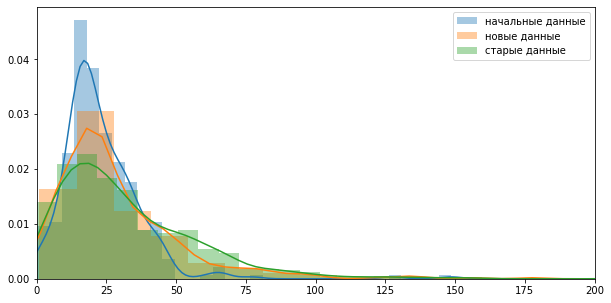

In [31]:
t0 = df_start['hours_diff_mean'].tolist()
t1 = df_new['hours_diff_mean'].tolist()
t2 = df_old['hours_diff_mean'].tolist()
plt.figure(figsize=(10, 5))
sb.distplot(t0, label = 'начальные данные')
sb.distplot(t1, label = 'новые данные')
sb.distplot(t2, label = 'старые данные')
print('Среднее время ответа')
plt.legend()
plt.xlim(0, 200)
plt.show()

Медиана времени ожидания ответа ответа


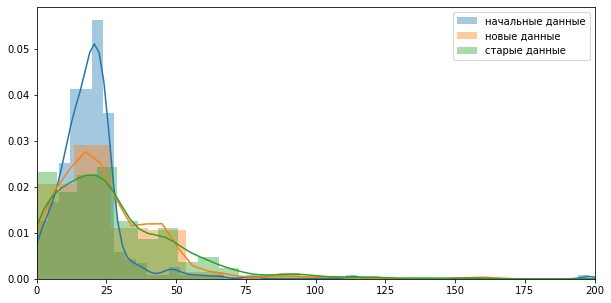

In [32]:
t0 = df_start['hours_diff_median'].tolist()
t1 = df_new['hours_diff_median'].tolist()
t2 = df_old['hours_diff_median'].tolist()
plt.figure(figsize=(10, 5))
sb.distplot(t0, label = 'начальные данные')
sb.distplot(t1, label = 'новые данные')
sb.distplot(t2, label = 'старые данные')
print('Медиана времени ожидания ответа ответа')
plt.legend()
plt.xlim(0, 200)
plt.show()